## Analysis
1. Urban area has the largest number of rides
2. Urban area has the largest number of drivers
3. Rurual area has fewest number of rides but higest average fares

## Imports and Constants

In [1]:
import os
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Use below data structus to facliate coloring
COLOR_MAP = OrderedDict([
    ('Urban', 'lightcoral'),
    ('Suburban', 'lightskyblue'),
    ('Rural', 'gold')
    ]
)
COLORS = [COLOR_MAP[t] for t in COLOR_MAP]
TYPES = [t for t in COLOR_MAP]

## Prepare Data
Instead of merging at ride level, created stat (summary) level data to hold higher level information, then as necessary computer details status using ride data and append as new columns to the stat (summary) DataFrame. This method can avoid the 'hacky' way of mean(driver count), and also comsume less memory in case the data size is large.

In [2]:
city_file = os.path.join('raw_data', 'city_data.csv')
df_city = pd.read_csv(city_file)
df_city.head()

,city,driver_count,type
0,Kelseyland,63,Urban
1,Nguyenbury,8,Urban
2,East Douglas,12,Urban
3,West Dawnfurt,34,Urban
4,Rodriguezburgh,52,Urban


In [3]:
ride_file = os.path.join('raw_data', 'ride_data.csv')
df_ride = pd.read_csv(ride_file)
df_ride.head()

,city,date,fare,ride_id
0,Sarabury,2016-01-16 13:49:27,38.35,5403689035038
1,South Roy,2016-01-02 18:42:34,17.49,4036272335942
2,Wiseborough,2016-01-21 17:35:29,44.18,3645042422587
3,Spencertown,2016-07-31 14:53:22,6.87,2242596575892
4,Nguyenbury,2016-07-09 04:42:44,6.28,1543057793673


### Merge Two Data Sets
Before merging ride data into city, summarize it first to avoid double couning of rides.

In [4]:
df_city_stat = df_city.merge(
    df_ride.groupby('city')[['fare', 'ride_id']].agg(
        {
            'fare': 'mean',
            'ride_id': 'count',
        }
    ).reset_index().rename(
        columns={
             'fare': 'fare_average',
             'ride_id': 'ride_count',
        }
    ),
    on='city',
    how='outer'
)
df_city_stat.head()

,city,driver_count,type,fare_average,ride_count
0,Kelseyland,63,Urban,21.806429,28
1,Nguyenbury,8,Urban,25.899615,26
2,East Douglas,12,Urban,26.169091,22
3,West Dawnfurt,34,Urban,22.330345,29
4,Rodriguezburgh,52,Urban,21.332609,23


## Bubble Plot of Ride Sharing Data

__Note__: When plotting the size is multiplied by 10 to show more apparent differences.

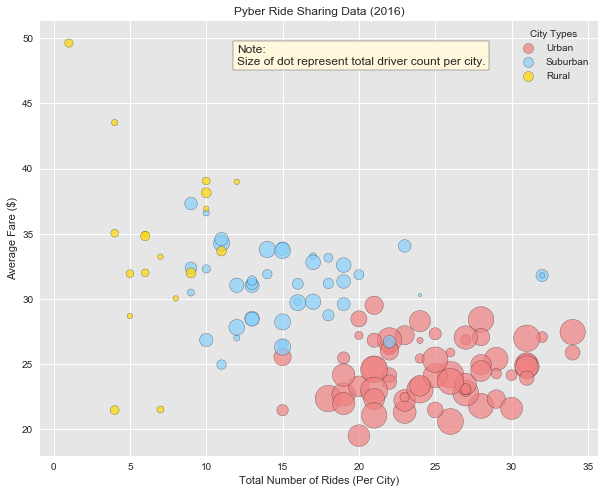

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))

# Multiply side by 10 to see differences easier
def plot_bubble(ax):
    legend = ax.legend(
        handles=[
            ax.scatter(
                s=df_city_stat.query('type==@type')['driver_count'] * 10,
                x=df_city_stat.query('type==@type')['ride_count'],
                y=df_city_stat.query('type==@type')['fare_average'],
                alpha=0.7,
                label=type,
                edgecolor='black',
                color=COLOR_MAP[type],
            ) for type in TYPES 
        ],
        title='City Types',
        loc='best',
    )
    for h in legend.legendHandles: h._sizes = [100]

    ax.text(12,48, 'Note:\nSize of dot represent total driver count per city.',
             fontsize=12,
             bbox=dict(facecolor='cornsilk'))

    plt.title('Pyber Ride Sharing Data (2016)')
    plt.xlabel('Total Number of Rides (Per City)')
    plt.ylabel('Average Fare ($)')

plot_bubble(ax)
plt.show()

## Total Fares by City Type

### Compute Total Fares for Each City
This data set can be used on all below three pie charts. Note here that total fare is retreived from ride data, instead of computed by fare average multiply by ride count to preserve original precision.

In [6]:
df_fare_total = df_ride.pivot_table(values='fare', index='city', aggfunc='sum').rename(
    columns={'fare': 'fare_total'}
).reset_index()
df_fare_total.head()

,city,fare_total
0,Alvarezhaven,741.79
1,Alyssaberg,535.85
2,Anitamouth,335.84
3,Antoniomouth,519.75
4,Aprilchester,417.65


### Same result with group by then sum()

In [7]:
df_fare_total = df_ride.groupby('city')['fare'].sum(
    ).to_frame().reset_index().rename(
        columns={
             'fare': 'fare_total',
        }
    )
df_fare_total.head()

,city,fare_total
0,Alvarezhaven,741.79
1,Alyssaberg,535.85
2,Anitamouth,335.84
3,Antoniomouth,519.75
4,Aprilchester,417.65


Reached same result using either groupby and sum() or pivot_table()

In [8]:
df_city_stat = df_city_stat.merge(
    df_fare_total,
    on='city',
    how='outer'
)
df_city_stat.head()

,city,driver_count,type,fare_average,ride_count,fare_total
0,Kelseyland,63,Urban,21.806429,28,610.58
1,Nguyenbury,8,Urban,25.899615,26,673.39
2,East Douglas,12,Urban,26.169091,22,575.72
3,West Dawnfurt,34,Urban,22.330345,29,647.58
4,Rodriguezburgh,52,Urban,21.332609,23,490.65


### Plot Pie Charts

In [9]:
PIE_STYLE = {
    'startangle': 140,
    'explode': [0.1, 0, 0],
    'shadow': True,
    'pctdistance': 0.6,
    'autopct': '%1.1f%%',
    'colors': COLORS,
    'labels': TYPES,
    'counterclock': False,
    'wedgeprops': {'linewidth': 1, 'edgecolor': 'grey'}
}

# Reindex with TYPES to ensure colors and orders match

def plot_fare(ax):
    plt.title('% of Total Fares by City Type')
    ax.pie(df_city_stat.groupby('type')['fare_total'].sum()[TYPES], **PIE_STYLE)
    plt.axis('equal')

def plot_ride(ax):
    plt.title('% of Total Rides by City Type')
    ax.pie(df_city_stat.groupby('type')['ride_count'].sum()[TYPES], **PIE_STYLE)
    plt.axis('equal')

def plot_driver(ax):
    plt.title('% of Total Drivers by City Type')
    ax.pie(df_city_stat.groupby('type')['driver_count'].sum()[TYPES], **PIE_STYLE)
    plt.axis('equal')

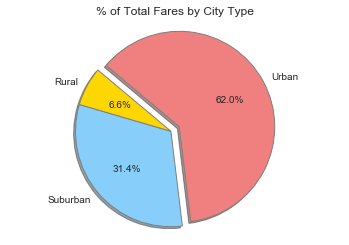

In [10]:
plot_fare(plt.subplot())
plt.show()

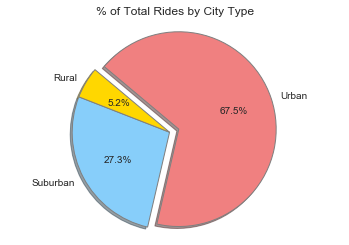

In [11]:
plot_ride(plt.subplot())
plt.show()

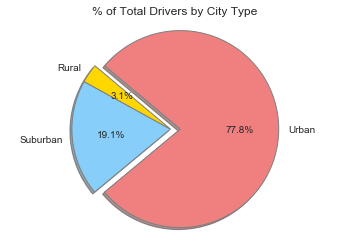

In [12]:
plot_driver(plt.subplot())
plt.show()

## All in One Figure

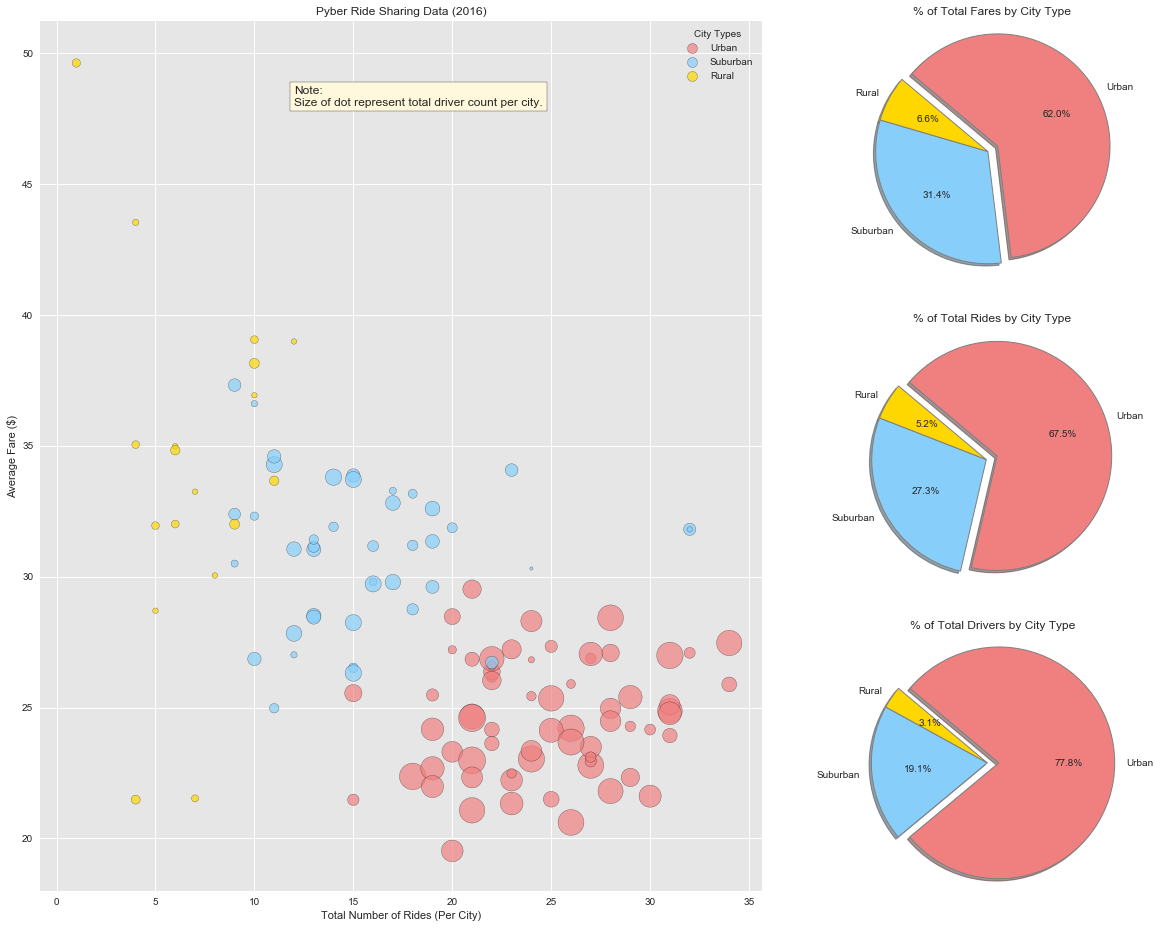

In [13]:
fig = plt.figure(figsize=(20,16))

plot_bubble(plt.subplot2grid( (3, 3), (0, 0), rowspan=3, colspan=2))
plot_fare(plt.subplot2grid((3, 3), (0, 2)))
plot_ride(plt.subplot2grid((3, 3), (1, 2)))
plot_driver(plt.subplot2grid((3, 3), (2, 2)))

plt.show()